In [1]:
import pandas as pd
import random
import numpy as np

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules
from sklearn import svm as svm

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

from sklearn.decomposition import PCA 


# Misc
import warnings
warnings.filterwarnings("ignore")
random.seed(1137)

In [2]:
dallas = pd.read_csv('data/processed/dallas_dv.csv')

In [6]:
y = dallas[['euthanasia']]
X = dallas.drop(columns=['euthanasia', 'city'])

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25, random_state=1137)

In [8]:
# Used throughout each model, doesn't need to be reset each time

fold_generator = KFold(n_splits=10, shuffle=True, random_state=1137)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])


search_space = [

        # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[10,20],
    'model__n_estimators':[500,1000],
    'model__random_state':[1137]},
]

In [9]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [10]:
search.fit(train_X,train_y.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=1137, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=20,
                                                           n_estimators=1000,
                                                           random_state=1137)],
                          'model__max_depth': [10, 20],
                          'model__n_estimators': [500, 1000],
                          'model__random_state': [1137]}],
             scoring='roc_auc')

In [11]:
search.best_score_

0.7748404061188178

In [12]:
rf_mod = search.best_estimator_

In [13]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.8039155750907473

In [14]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.8546859903381643

In [15]:
# Mean Test Score Comparison Table Creation
# store scores and standard errors for building confidence intervals
scores = search.cv_results_.get('mean_test_score')
errors = search.cv_results_.get('std_test_score')

search.cv_results_.get('params')
models = [

    'RandomForest, maxdepth:10, trees:500',
    'RandomForest, maxdepth:10, trees:1000',
    'RandomForest, maxdepth:20, trees:500',
    'RandomForest, maxdepth:20, trees:1000',
]
# create dataframe of models, scores, and errors
d = {'model':models, 'mean_test_score':scores, 'mean_st_err':errors}
table = pd.DataFrame(data=d)
# create confidence intervals
table['low'] = table['mean_test_score'] - 2*table['mean_st_err']
table['high'] = table['mean_test_score'] + 2*table['mean_st_err']
table['max'] = (table['mean_test_score'] == table['mean_test_score'].max())

table

,model,mean_test_score,mean_st_err,low,high,max
0,"RandomForest, maxdepth:10, trees:500",0.762806,0.009257,0.744291,0.781321,False
1,"RandomForest, maxdepth:10, trees:1000",0.762091,0.009468,0.743154,0.781027,False
2,"RandomForest, maxdepth:20, trees:500",0.774808,0.009296,0.756215,0.793401,False
3,"RandomForest, maxdepth:20, trees:1000",0.774840,0.009301,0.756239,0.793442,True


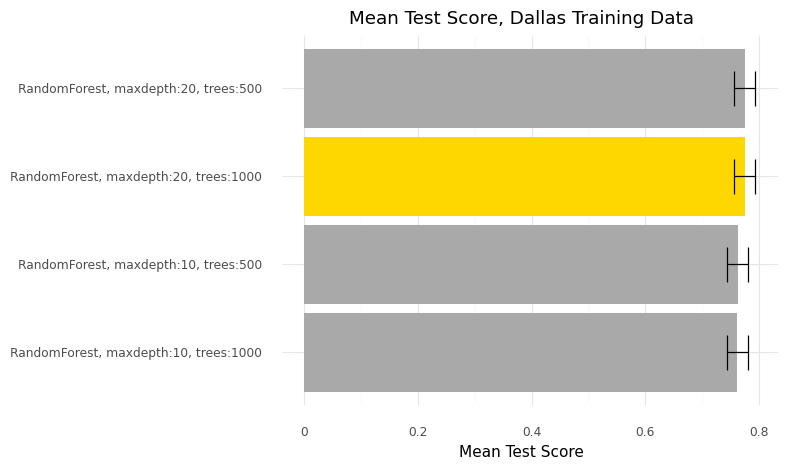

<ggplot: (8770214514351)>

In [16]:
(
ggplot(table, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','gold'), guide=None) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title='Mean Test Score, Dallas Training Data') + 
    theme_minimal()
)

In [17]:
preds = rf_mod.predict_proba(train_X)[:,1]

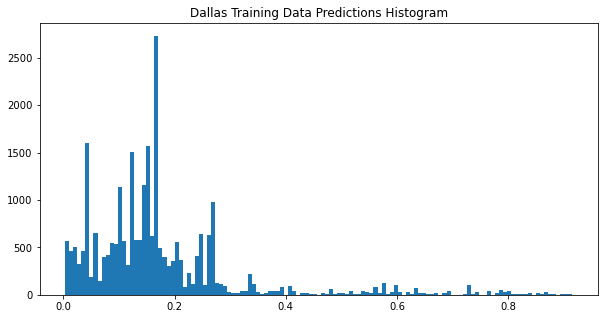

In [26]:
# plot the distribution of prediction values to better understand model's response to training data

plt.hist(preds, bins='auto')
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Dallas Training Data Predictions Histogram")
plt.show()


              precision    recall  f1-score   support

           0       0.86      0.99      0.92     21403
           1       0.78      0.22      0.35      4472

    accuracy                           0.85     25875
   macro avg       0.82      0.60      0.63     25875
weighted avg       0.85      0.85      0.82     25875



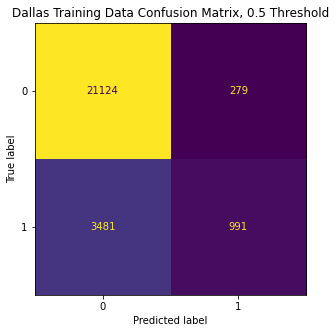

In [43]:
# create the confusion matrix with shifting threshold for evaluating precision and recall

preds_bin = preds.copy()

preds_bin = np.where(preds_bin >= .5, 1, preds_bin)
preds_bin = np.where(preds_bin < .5, 0, preds_bin)

print(m.classification_report(train_y, preds_bin))

m.ConfusionMatrixDisplay.from_predictions(train_y, preds_bin, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Dallas Training Data Confusion Matrix, 0.5 Threshold')
plt.show()

## Dallas Variable Importance

In [20]:
## Feature Importance

vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=3)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat



# store
#vi_dat.to_csv("vi_dat_20_800.csv", index=False)


,variable,vi,std,low,high
0,intake_condition_unhealthy,0.025250,0.000648,0.023953,0.026547
1,intake_type_owner surrender,0.014634,0.000840,0.012954,0.016315
2,intake_condition_injured,0.010718,0.000811,0.009096,0.012340
3,intake_condition_healthy,0.005127,0.000324,0.004479,0.005775
4,intake_type_stray,0.003491,0.000623,0.002244,0.004738
...,...,...,...,...,...
242,harrier,0.000000,0.000000,0.000000,0.000000
243,maltese,-0.000013,0.000018,-0.000049,0.000024
244,st bernard smooth coat,-0.000013,0.000018,-0.000049,0.000024
245,airedale terrier,-0.000013,0.000018,-0.000049,0.000024


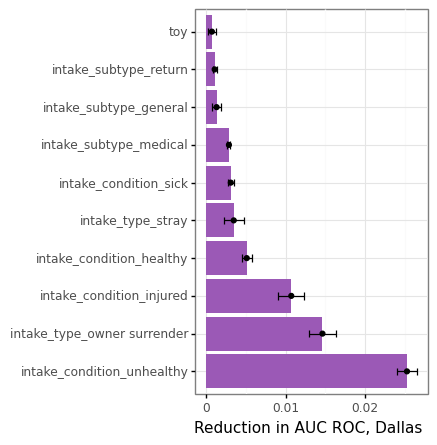

<ggplot: (8770252049604)>

In [49]:
# Plot the most important variables
(
    ggplot(vi_dat[0:10],
          aes(x="variable",y="vi")) +
    geom_col(fill="#9b59b6") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[0:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC, Dallas",x="") + 
    theme(figure_size=(3,5))
         )

## Dallas Test Data

In [22]:
# store the predicted values from the test data for graphing and adding to the confusion matrix below
preds_t = rf_mod.predict_proba(test_X)[:,1]

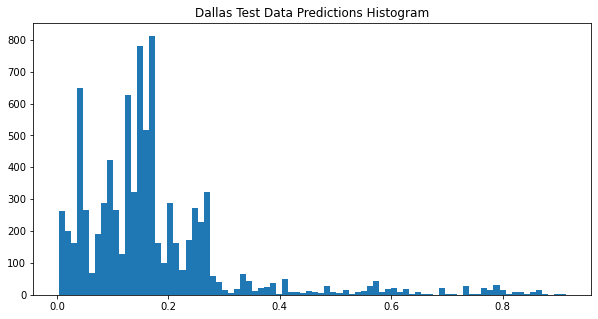

In [32]:
plt.hist(preds_t, bins='auto')
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Dallas Test Data Predictions Histogram")
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      7122
           1       0.76      0.20      0.32      1503

    accuracy                           0.85      8625
   macro avg       0.81      0.59      0.62      8625
weighted avg       0.84      0.85      0.81      8625



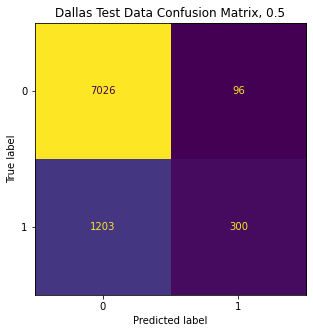

In [45]:
preds_bin_t = preds_t.copy()

preds_bin_t = np.where(preds_bin_t >= .5, 1, preds_bin_t)
preds_bin_t = np.where(preds_bin_t < .5, 0, preds_bin_t)

print(m.classification_report(test_y, preds_bin_t))

m.ConfusionMatrixDisplay.from_predictions(test_y, preds_bin_t, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Dallas Test Data Confusion Matrix, 0.5')
plt.show()